# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

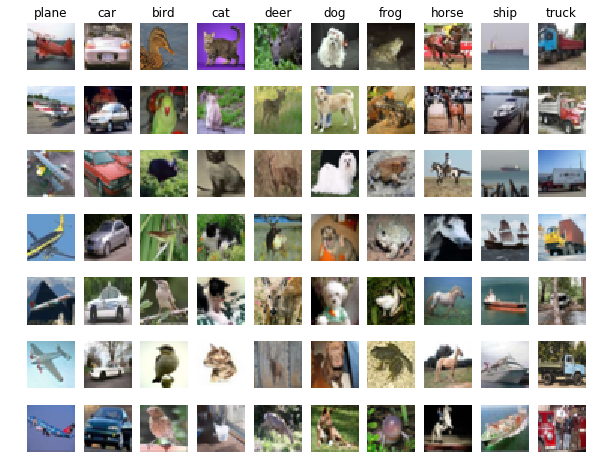

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ> Увеличение инструментов для корректировки затухания градиента, числа блоков.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>  Затухание (взрыв) градиента, недо/пере -обучение 


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ> Переобчение. Использовать специальные инструменты такие как DropOut ... 

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>  


In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [5]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

data = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
in_channels = 3
for x in data:
    if x == 'M':
        net = lasagne.layers.MaxPool2DLayer(net, pool_size=2, stride=2)
    else:
        net = lasagne.layers.Conv2DLayer(net, x, filter_size=3, pad=1)
        net = lasagne.layers.BatchNormLayer(net, axes = 'auto')
        net = lasagne.layers.NonlinearityLayer(net, nonlinearity=rectify)
        in_channels = x
lasagne.layers.Pool2DLayer(net, pool_size=1, stride=1)

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)

In [6]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net)
print all_weights

[W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b, beta, gamma, mean, inv_std, W, b]


In [8]:
all_weights = lasagne.layers.get_all_params(net, trainable=True)
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates = lasagne.updates.momentum(loss, all_weights, learning_rate=0.9)

In [9]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates= updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [12]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 0 of 10 took 163.019s
 training loss (in-iteration):		3.083231
 train accuracy:		42.33 %
 validation accuracy:		41.24 %
Epoch 1 of 10 took 162.837s
 training loss (in-iteration):		2.570245
 train accuracy:		53.92 %
 validation accuracy:		52.03 %
Epoch 2 of 10 took 163.379s
 training loss (in-iteration):		1.972354
 train accuracy:		64.77 %
 validation accuracy:		62.98 %
Epoch 3 of 10 took 162.880s
 training loss (in-iteration):		1.932566
 train accuracy:		66.01 %
 validation accuracy:		65.94 %
Epoch 4 of 10 took 162.525s
 training loss (in-iteration):		1.918434
 train accuracy:		68.97 %
 validation accuracy:		65.22 %
Epoch 5 of 10 took 162.979s
 training loss (in-iteration):		1.818347
 train accuracy:		69.31 %
 validation accuracy:		67.38 %
Epoch 6 of 10 took 163.655s
 training loss (in-iteration):		1.656213
 train accuracy:		70.13 %
 validation accuracy:		69.82 %
Epoch 7 of 10 took 162.673s
 training loss (in-iteration):		1.566327
 train accuracy:		71.42 %
 validation accuracy:		

In [13]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		67.23 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 